### **개요: resnet18을 파인튜닝하여 재료 이미지에 대한 Classification을 진행하는 AI 모델을 생성합니다.**

In [1]:
!pip install tqdm
!pip install kaggle

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from tqdm import tqdm
from google.colab import drive, files
import matplotlib.pyplot as plt

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Epoch별 결과값 배열
train_losses = []
train_acc = []
val_losses = []
val_acc = []

In [5]:
'''
* training_recognition_ai(): epoch 10회 단위로 Fine-tuning을 진행하는 함수
* parameter
* 1. model: 학습을 진행할 모델
* 2. train_dataset: 전처리를 거친 Training Dataset
* 3. val_dataset: 전처리를 거친 Validation Dataset
* 4. save_dir: Finetuning을 마친 모델을 저장할 경로
'''
def training_recognition_ai(model, train_dataset, val_dataset, save_dir):
    global train_losses, train_acc, val_losses, val_acc
    # 데이터로더 설정
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
    val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

    # 클래스 수 설정
    class_names = train_dataset.classes

    # GPU 사용 여부 확인
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # 새로운 분류기 추가 (Fine-tuning을 위해 마지막 Fully Connected 레이어를 변경)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, len(class_names))

    # GPU 또는 CPU에 모델 올리기
    model = model.to(device)

    # 손실 함수 정의
    criterion = nn.CrossEntropyLoss()

    # 옵티마이저 정의 (SGD를 사용하며, 매개변수 및 학습률 조절을 위해 scheduler 사용)
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    # 7 에폭마다 학습률을 감소시키는 스케줄러
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    # 모델 학습
    num_epochs = 20
    for epoch in range(num_epochs):

        # 학습과 검증을 번갈아가면서 진행
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 학습 모드 설정
                dataloader = tqdm(train_dataloader, desc=f'Training Epoch {epoch}', position=0, leave=True)
            else:
                model.eval()   # 평가 모드 설정
                dataloader = tqdm(val_dataloader, desc=f'Validation Epoch {epoch}', position=0, leave=True)

            running_loss = 0.0
            running_corrects = 0

            # 데이터 반복
            for inputs, labels in dataloader:
                inputs, labels = inputs.to(device), labels.to(device)

                # 매개변수 경사도 초기화
                optimizer.zero_grad()

                # 순전파
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 학습 단계인 경우 역전파 및 옵티마이저 최적화
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 통계
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                if phase == 'train':
                    dataloader.set_postfix({'Loss': loss.item()})

            # 에폭 당 손실과 정확도 계산
            epoch_loss = running_loss / len(train_dataloader.dataset) if phase == 'train' else running_loss / len(val_dataloader.dataset)
            epoch_acc = running_corrects.double() / len(train_dataloader.dataset) if phase == 'train' else running_corrects.double() / len(val_dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
              train_losses.append(epoch_loss)
              train_acc.append(epoch_acc)
            else:
              val_losses.append(epoch_loss)
              val_acc.append(epoch_acc)
        # 학습률 스케줄러 업데이트
        exp_lr_scheduler.step()

    # 모델 저장
    torch.save(model, save_dir)

    # 그래프 그리기
    plot_result(train_losses, train_acc, val_losses, val_acc)

    return model


In [6]:
'''
* plot_result(): Training Loss, Training Accuracy, Validation Loss, Validation Accuracy를 plot하는 함수
* parameter
* 1. train_losses: Epoch별 Training Loss 배열
* 2. train_acc: Epoch별 Training Accuracy 배열
* 3. val_losses: Epoch별 Validation Loss 배열
* 4. val_acc: Epoch별 Validation Accuracy 배열
'''
def plot_result(train_losses, train_acc, val_losses, val_acc):
    epochs = range(1, len(train_losses) + 1)

    # Training Loss와 Validation Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss', marker='o')
    plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Training Accuracy와 Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='Train Accuracy', marker='o')
    plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [7]:
# 데이터 전처리
data_transforms = {
    'train': transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
    ]),
}

1. Kaggle 사이트에서 fruit-and-vegitable-image 데이터셋을 다운받고, 압축을 해제합니다.

In [8]:
# Kaggle.json 파일을 /root/.kaggle/ 디렉토리로 복사
!mkdir -p /root/.kaggle/
!cp /content/drive/MyDrive/Recipes_ChatBot/kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

# Kaggle에서 데이터셋 다운로드
!kaggle datasets download -d kritikseth/fruit-and-vegetable-image-recognition

# 다운로드된 ZIP 파일 압축 해제
!unzip -q fruit-and-vegetable-image-recognition.zip -d /content/drive/MyDrive/Recipes_ChatBot/data/fruit-and-vegetable-image-recognition

100% 1.98G/1.98G [00:24<00:00, 127MB/s]
100% 1.98G/1.98G [00:24<00:00, 87.1MB/s]
replace /content/drive/MyDrive/Recipes_ChatBot/data/fruit-and-vegetable-image-recognition/test/apple/Image_1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

2. 다운받은 데이터셋을 전처리하여 **train_dataset**과 **val_dataset**에 저장하고, Training이 끝난 다음 모델을 저장할 경로를 **save_dir**에 저장합니다.

In [9]:
# 음식 재료 데이터셋 디렉토리 경로 설정
data_dir = '/content/drive/MyDrive/Recipes_ChatBot/data/fruit-and-vegetable-image-recognition'

# 드라이브에 저장된 데이터셋 로드
train_dataset = datasets.ImageFolder(root=f"{data_dir}/train", transform=data_transforms['train'])
val_dataset = datasets.ImageFolder(root=f"{data_dir}/test", transform=data_transforms['val'])

# 모델을 저장할 링크 명시
save_dir = '/content/drive/MyDrive/Recipes_ChatBot/food_ingredient_recognition_model.pth'

3. ImageNet으로 Pre-trained된 resnet18을 로드한 후, fruit-and-vegetable-image 데이터셋으로 Fine-tuning하는 **Transfer learning**을 진행합니다.
>
(참고: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Training Epoch 0:   1%|          | 1/98 [00:23<37:55, 23.46s/it, Loss=3.64]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 0:  13%|█▎        | 13/98 [02:27<15:25, 10.89s/it, Loss=3.71]/usr/local/lib/python3.10/dist-packages/PIL/Image.p

train Loss: 2.6591 Acc: 0.3711


Validation Epoch 0: 100%|██████████| 12/12 [01:01<00:00,  5.16s/it]


val Loss: 1.1058 Acc: 0.7632


Training Epoch 1:   0%|          | 0/98 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 1:  19%|█▉        | 19/98 [03:09<12:43,  9.66s/it, Loss=1.53]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 1: 100%|██████████| 98/98 [15:48<00:00,  9.68s/it, Loss=1.29]


train Loss: 1.3136 Acc: 0.6937


Validation Epoch 1: 100%|██████████| 12/12 [00:50<00:00,  4.20s/it]


val Loss: 0.5520 Acc: 0.8691


Training Epoch 2:   1%|          | 1/98 [00:15<24:31, 15.17s/it, Loss=0.95]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 2:  27%|██▋       | 26/98 [04:17<11:47,  9.83s/it, Loss=0.884]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 2: 100%|██████████| 98/98 [15:43<00:00,  9.63s/it, Loss=1.07]


train Loss: 0.9362 Acc: 0.7644


Validation Epoch 2: 100%|██████████| 12/12 [00:49<00:00,  4.11s/it]


val Loss: 0.4065 Acc: 0.8747


Training Epoch 3:   0%|          | 0/98 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 3:   3%|▎         | 3/98 [00:33<16:37, 10.50s/it, Loss=0.808]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 3: 100%|██████████| 98/98 [15:55<00:00,  9.75s/it, Loss=0.479]


train Loss: 0.7872 Acc: 0.7920


Validation Epoch 3: 100%|██████████| 12/12 [00:49<00:00,  4.12s/it]


val Loss: 0.3306 Acc: 0.8774


Training Epoch 4:  10%|█         | 10/98 [01:40<13:48,  9.42s/it, Loss=0.678]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 4:  36%|███▌      | 35/98 [05:41<10:13,  9.73s/it, Loss=0.517]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 4: 100%|██████████| 98/98 [15:51<00:00,  9.71s/it, Loss=1.04]


train Loss: 0.6846 Acc: 0.8061


Validation Epoch 4: 100%|██████████| 12/12 [00:58<00:00,  4.85s/it]


val Loss: 0.2917 Acc: 0.8942


Training Epoch 5:   0%|          | 0/98 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 5:  13%|█▎        | 13/98 [02:14<13:47,  9.74s/it, Loss=0.449]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 5: 100%|██████████| 98/98 [16:12<00:00,  9.93s/it, Loss=0.686]


train Loss: 0.6052 Acc: 0.8318


Validation Epoch 5: 100%|██████████| 12/12 [00:49<00:00,  4.17s/it]


val Loss: 0.2704 Acc: 0.9053


Training Epoch 6:   4%|▍         | 4/98 [00:46<17:13, 10.99s/it, Loss=0.486]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 6:  19%|█▉        | 19/98 [03:19<13:27, 10.22s/it, Loss=0.448]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 6: 100%|██████████| 98/98 [16:17<00:00,  9.97s/it, Loss=0.432]


train Loss: 0.5531 Acc: 0.8430


Validation Epoch 6: 100%|██████████| 12/12 [00:50<00:00,  4.17s/it]


val Loss: 0.2411 Acc: 0.9109


Training Epoch 7:  14%|█▍        | 14/98 [02:21<13:36,  9.72s/it, Loss=0.263]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 7:  19%|█▉        | 19/98 [03:09<13:04,  9.94s/it, Loss=0.598]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 7: 100%|██████████| 98/98 [16:07<00:00,  9.87s/it, Loss=0.704]


train Loss: 0.5076 Acc: 0.8543


Validation Epoch 7: 100%|██████████| 12/12 [00:50<00:00,  4.19s/it]


val Loss: 0.2256 Acc: 0.9248


Training Epoch 8:  14%|█▍        | 14/98 [02:26<14:31, 10.38s/it, Loss=0.543]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 8:  38%|███▊      | 37/98 [06:10<09:35,  9.44s/it, Loss=0.362]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 8: 100%|██████████| 98/98 [16:05<00:00,  9.85s/it, Loss=1.01]


train Loss: 0.5086 Acc: 0.8565


Validation Epoch 8: 100%|██████████| 12/12 [00:49<00:00,  4.09s/it]


val Loss: 0.2312 Acc: 0.9164


Training Epoch 9:   0%|          | 0/98 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 9:   9%|▉         | 9/98 [01:32<14:05,  9.50s/it, Loss=0.484]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 9: 100%|██████████| 98/98 [16:02<00:00,  9.82s/it, Loss=0.408]


train Loss: 0.5118 Acc: 0.8549


Validation Epoch 9: 100%|██████████| 12/12 [00:49<00:00,  4.14s/it]


val Loss: 0.2214 Acc: 0.9276


Training Epoch 10:   2%|▏         | 2/98 [00:25<19:30, 12.19s/it, Loss=0.884]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 10:  11%|█         | 11/98 [01:55<14:27,  9.97s/it, Loss=0.509]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 10: 100%|██████████| 98/98 [16:05<00:00,  9.85s/it, Loss=0.553]


train Loss: 0.4839 Acc: 0.8668


Validation Epoch 10: 100%|██████████| 12/12 [00:50<00:00,  4.18s/it]


val Loss: 0.2165 Acc: 0.9220


Training Epoch 11:  26%|██▌       | 25/98 [04:16<11:33,  9.51s/it, Loss=0.574]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 11:  35%|███▍      | 34/98 [05:45<10:28,  9.82s/it, Loss=0.38]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 11: 100%|██████████| 98/98 [16:04<00:00,  9.84s/it, Loss=0.232]


train Loss: 0.4927 Acc: 0.8584


Validation Epoch 11: 100%|██████████| 12/12 [00:49<00:00,  4.14s/it]


val Loss: 0.2142 Acc: 0.9248


Training Epoch 12:  11%|█         | 11/98 [01:55<13:59,  9.65s/it, Loss=0.315]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 12:  29%|██▊       | 28/98 [04:49<11:34,  9.91s/it, Loss=0.439]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 12: 100%|██████████| 98/98 [16:12<00:00,  9.92s/it, Loss=0.219]


train Loss: 0.4855 Acc: 0.8703


Validation Epoch 12: 100%|██████████| 12/12 [00:50<00:00,  4.18s/it]


val Loss: 0.2163 Acc: 0.9248


Training Epoch 13:  15%|█▌        | 15/98 [02:33<13:04,  9.46s/it, Loss=0.284]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 13:  16%|█▋        | 16/98 [02:44<13:37,  9.97s/it, Loss=0.697]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 13: 100%|██████████| 98/98 [16:17<00:00,  9.98s/it, Loss=0.597]


train Loss: 0.4765 Acc: 0.8681


Validation Epoch 13: 100%|██████████| 12/12 [00:56<00:00,  4.72s/it]


val Loss: 0.2130 Acc: 0.9248


Training Epoch 14:   0%|          | 0/98 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 14:  18%|█▊        | 18/98 [03:03<12:54,  9.68s/it, Loss=0.494]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 14: 100%|██████████| 98/98 [16:10<00:00,  9.91s/it, Loss=0.299]


train Loss: 0.4767 Acc: 0.8684


Validation Epoch 14: 100%|██████████| 12/12 [00:49<00:00,  4.16s/it]


val Loss: 0.2183 Acc: 0.9192


Training Epoch 15:   1%|          | 1/98 [00:19<30:53, 19.11s/it, Loss=0.92]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 15:   8%|▊         | 8/98 [01:27<14:45,  9.84s/it, Loss=0.557]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 15: 100%|██████████| 98/98 [16:16<00:00,  9.97s/it, Loss=0.426]


train Loss: 0.4760 Acc: 0.8575


Validation Epoch 15: 100%|██████████| 12/12 [00:49<00:00,  4.16s/it]


val Loss: 0.2192 Acc: 0.9248


Training Epoch 16:   0%|          | 0/98 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 16:  36%|███▌      | 35/98 [05:56<12:10, 11.59s/it, Loss=0.945]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 16: 100%|██████████| 98/98 [16:13<00:00,  9.94s/it, Loss=0.284]


train Loss: 0.4680 Acc: 0.8700


Validation Epoch 16: 100%|██████████| 12/12 [00:49<00:00,  4.16s/it]


val Loss: 0.2145 Acc: 0.9220


Training Epoch 17:   8%|▊         | 8/98 [01:24<15:06, 10.07s/it, Loss=0.547]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 17:  11%|█         | 11/98 [01:55<14:42, 10.15s/it, Loss=0.562]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 17: 100%|██████████| 98/98 [16:07<00:00,  9.87s/it, Loss=0.781]


train Loss: 0.4698 Acc: 0.8687


Validation Epoch 17: 100%|██████████| 12/12 [00:49<00:00,  4.15s/it]


val Loss: 0.2214 Acc: 0.9192


Training Epoch 18:   3%|▎         | 3/98 [00:33<17:14, 10.89s/it, Loss=0.608]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 18:  29%|██▊       | 28/98 [04:43<11:39,  9.99s/it, Loss=0.494]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 18: 100%|██████████| 98/98 [16:10<00:00,  9.90s/it, Loss=0.439]


train Loss: 0.4636 Acc: 0.8700


Validation Epoch 18: 100%|██████████| 12/12 [00:49<00:00,  4.12s/it]


val Loss: 0.2131 Acc: 0.9248


Training Epoch 19:   0%|          | 0/98 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 19: 100%|██████████| 98/98 [16:13<00:00,  9.93s/it, Loss=0.497]


train Loss: 0.4533 Acc: 0.8754


Validation Epoch 19: 100%|██████████| 12/12 [00:49<00:00,  4.11s/it]


val Loss: 0.2148 Acc: 0.9220


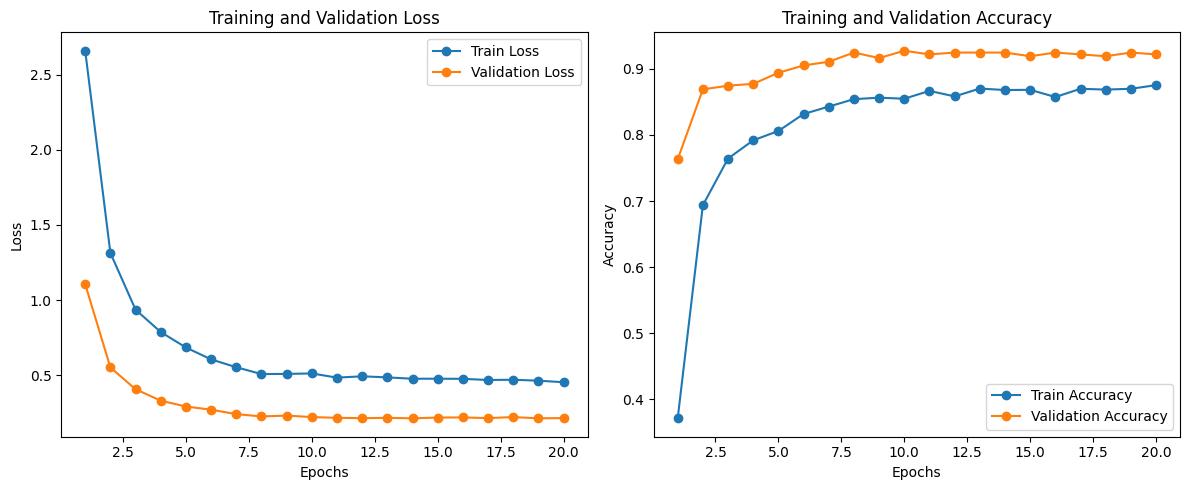

In [13]:
# 미리 학습된 ResNet-18 모델 불러오기
model = models.resnet18(pretrained=True)

model = training_recognition_ai(model, train_dataset, val_dataset, save_dir)

4. 정확도가 낮아, Epoch 20회를 추가로 더 진행했습니다.

Training Epoch 0:   0%|          | 0/98 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 0:  10%|█         | 10/98 [01:49<15:15, 10.40s/it, Loss=3.47]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 0: 100%|██████████| 98/98 [16:51<00:00, 10.32s/it, Loss=1.15]


train Loss: 2.0301 Acc: 0.5339


Validation Epoch 0: 100%|██████████| 12/12 [00:52<00:00,  4.41s/it]


val Loss: 0.4844 Acc: 0.8747


Training Epoch 1:   0%|          | 0/98 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 1:  35%|███▍      | 34/98 [05:49<11:09, 10.47s/it, Loss=0.783]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 1: 100%|██████████| 98/98 [16:39<00:00, 10.20s/it, Loss=0.937]


train Loss: 0.8329 Acc: 0.7907


Validation Epoch 1: 100%|██████████| 12/12 [00:53<00:00,  4.42s/it]


val Loss: 0.3096 Acc: 0.8914


Training Epoch 2:   2%|▏         | 2/98 [00:24<19:29, 12.19s/it, Loss=0.762]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 2:  17%|█▋        | 17/98 [02:54<12:59,  9.62s/it, Loss=0.586]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 2: 100%|██████████| 98/98 [16:36<00:00, 10.17s/it, Loss=1.18]


train Loss: 0.6710 Acc: 0.8080


Validation Epoch 2: 100%|██████████| 12/12 [00:53<00:00,  4.43s/it]


val Loss: 0.2684 Acc: 0.9109


Training Epoch 3:   4%|▍         | 4/98 [00:44<16:04, 10.26s/it, Loss=0.518]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 3:  44%|████▍     | 43/98 [07:28<09:23, 10.25s/it, Loss=0.657]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 3: 100%|██████████| 98/98 [16:38<00:00, 10.19s/it, Loss=0.882]


train Loss: 0.5757 Acc: 0.8311


Validation Epoch 3: 100%|██████████| 12/12 [00:51<00:00,  4.27s/it]


val Loss: 0.2554 Acc: 0.9136


Training Epoch 4:   3%|▎         | 3/98 [00:35<17:43, 11.19s/it, Loss=0.704]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 4:  14%|█▍        | 14/98 [02:26<14:11, 10.14s/it, Loss=0.668]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 4: 100%|██████████| 98/98 [16:39<00:00, 10.20s/it, Loss=0.751]


train Loss: 0.5203 Acc: 0.8517


Validation Epoch 4: 100%|██████████| 12/12 [00:52<00:00,  4.39s/it]


val Loss: 0.2206 Acc: 0.9304


Training Epoch 5:   0%|          | 0/98 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 5:  31%|███       | 30/98 [05:07<11:20, 10.00s/it, Loss=0.332]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 5: 100%|██████████| 98/98 [16:33<00:00, 10.14s/it, Loss=1.31]


train Loss: 0.4942 Acc: 0.8549


Validation Epoch 5: 100%|██████████| 12/12 [00:56<00:00,  4.72s/it]


val Loss: 0.2307 Acc: 0.9136


Training Epoch 6:   0%|          | 0/98 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 6: 100%|██████████| 98/98 [16:52<00:00, 10.33s/it, Loss=0.971]


train Loss: 0.4569 Acc: 0.8581


Validation Epoch 6: 100%|██████████| 12/12 [00:52<00:00,  4.41s/it]


val Loss: 0.2036 Acc: 0.9220


Training Epoch 7:   0%|          | 0/98 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 7:  13%|█▎        | 13/98 [02:16<14:12, 10.03s/it, Loss=0.28]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 7: 100%|██████████| 98/98 [16:40<00:00, 10.21s/it, Loss=0.541]


train Loss: 0.4320 Acc: 0.8681


Validation Epoch 7: 100%|██████████| 12/12 [00:56<00:00,  4.69s/it]


val Loss: 0.2053 Acc: 0.9276


Training Epoch 8:   5%|▌         | 5/98 [00:56<16:22, 10.56s/it, Loss=0.597]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 8:  12%|█▏        | 12/98 [02:07<14:36, 10.20s/it, Loss=0.331]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 8: 100%|██████████| 98/98 [16:51<00:00, 10.32s/it, Loss=1.19]


train Loss: 0.4152 Acc: 0.8729


Validation Epoch 8: 100%|██████████| 12/12 [00:52<00:00,  4.41s/it]


val Loss: 0.2025 Acc: 0.9276


Training Epoch 9:   1%|          | 1/98 [00:17<27:37, 17.09s/it, Loss=0.533]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 9:  18%|█▊        | 18/98 [03:09<13:26, 10.08s/it, Loss=0.289]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 9: 100%|██████████| 98/98 [16:44<00:00, 10.25s/it, Loss=1.48]


train Loss: 0.3893 Acc: 0.8809


Validation Epoch 9: 100%|██████████| 12/12 [00:51<00:00,  4.25s/it]


val Loss: 0.2004 Acc: 0.9276


Training Epoch 10:   0%|          | 0/98 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 10:  20%|██        | 20/98 [03:38<13:44, 10.57s/it, Loss=0.495]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 10: 100%|██████████| 98/98 [16:57<00:00, 10.39s/it, Loss=0.847]


train Loss: 0.3979 Acc: 0.8825


Validation Epoch 10: 100%|██████████| 12/12 [00:52<00:00,  4.40s/it]


val Loss: 0.1940 Acc: 0.9304


Training Epoch 11:   0%|          | 0/98 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 11:  22%|██▏       | 22/98 [03:59<13:49, 10.92s/it, Loss=0.47]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 11: 100%|██████████| 98/98 [16:51<00:00, 10.32s/it, Loss=0.376]


train Loss: 0.3912 Acc: 0.8848


Validation Epoch 11: 100%|██████████| 12/12 [00:50<00:00,  4.20s/it]


val Loss: 0.1928 Acc: 0.9248


Training Epoch 12:   1%|          | 1/98 [00:14<23:57, 14.82s/it, Loss=0.484]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 12:  10%|█         | 10/98 [01:47<14:20,  9.77s/it, Loss=0.259]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 12: 100%|██████████| 98/98 [16:55<00:00, 10.36s/it, Loss=0.614]


train Loss: 0.4061 Acc: 0.8787


Validation Epoch 12: 100%|██████████| 12/12 [00:52<00:00,  4.40s/it]


val Loss: 0.1923 Acc: 0.9304


Training Epoch 13:   0%|          | 0/98 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 13:  27%|██▋       | 26/98 [04:32<12:21, 10.30s/it, Loss=0.319]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 13: 100%|██████████| 98/98 [16:43<00:00, 10.24s/it, Loss=0.289]


train Loss: 0.3783 Acc: 0.8921


Validation Epoch 13: 100%|██████████| 12/12 [00:51<00:00,  4.26s/it]


val Loss: 0.1947 Acc: 0.9192


Training Epoch 14:   2%|▏         | 2/98 [00:26<20:42, 12.94s/it, Loss=0.27]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 14:  32%|███▏      | 31/98 [05:28<11:42, 10.49s/it, Loss=0.661]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 14: 100%|██████████| 98/98 [16:46<00:00, 10.27s/it, Loss=0.693]


train Loss: 0.3927 Acc: 0.8909


Validation Epoch 14: 100%|██████████| 12/12 [00:52<00:00,  4.39s/it]


val Loss: 0.1876 Acc: 0.9248


Training Epoch 15:   3%|▎         | 3/98 [00:34<18:02, 11.39s/it, Loss=0.322]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 15:  18%|█▊        | 18/98 [03:05<13:35, 10.19s/it, Loss=0.374]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 15: 100%|██████████| 98/98 [16:46<00:00, 10.27s/it, Loss=0.698]


train Loss: 0.3749 Acc: 0.8841


Validation Epoch 15: 100%|██████████| 12/12 [00:52<00:00,  4.39s/it]


val Loss: 0.1965 Acc: 0.9192


Training Epoch 16:   0%|          | 0/98 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 16:   6%|▌         | 6/98 [01:09<16:33, 10.80s/it, Loss=0.215]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 16: 100%|██████████| 98/98 [16:49<00:00, 10.30s/it, Loss=0.77]


train Loss: 0.3818 Acc: 0.8860


Validation Epoch 16: 100%|██████████| 12/12 [00:51<00:00,  4.25s/it]


val Loss: 0.1940 Acc: 0.9220


Training Epoch 17:  13%|█▎        | 13/98 [02:21<14:53, 10.51s/it, Loss=0.375]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 17:  27%|██▋       | 26/98 [04:33<11:50,  9.86s/it, Loss=0.19]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 17: 100%|██████████| 98/98 [16:45<00:00, 10.26s/it, Loss=0.504]


train Loss: 0.3786 Acc: 0.8851


Validation Epoch 17: 100%|██████████| 12/12 [00:51<00:00,  4.26s/it]


val Loss: 0.1917 Acc: 0.9276


Training Epoch 18:  14%|█▍        | 14/98 [02:43<14:40, 10.48s/it, Loss=0.335]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 18:  23%|██▎       | 23/98 [04:16<12:37, 10.10s/it, Loss=0.351]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 18: 100%|██████████| 98/98 [17:05<00:00, 10.47s/it, Loss=0.379]


train Loss: 0.3735 Acc: 0.8902


Validation Epoch 18: 100%|██████████| 12/12 [00:53<00:00,  4.43s/it]


val Loss: 0.1900 Acc: 0.9304


Training Epoch 19:   0%|          | 0/98 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 19:   7%|▋         | 7/98 [01:20<16:22, 10.80s/it, Loss=0.648]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 19: 100%|██████████| 98/98 [16:52<00:00, 10.33s/it, Loss=0.741]


train Loss: 0.3897 Acc: 0.8902


Validation Epoch 19: 100%|██████████| 12/12 [00:51<00:00,  4.30s/it]


val Loss: 0.1915 Acc: 0.9276


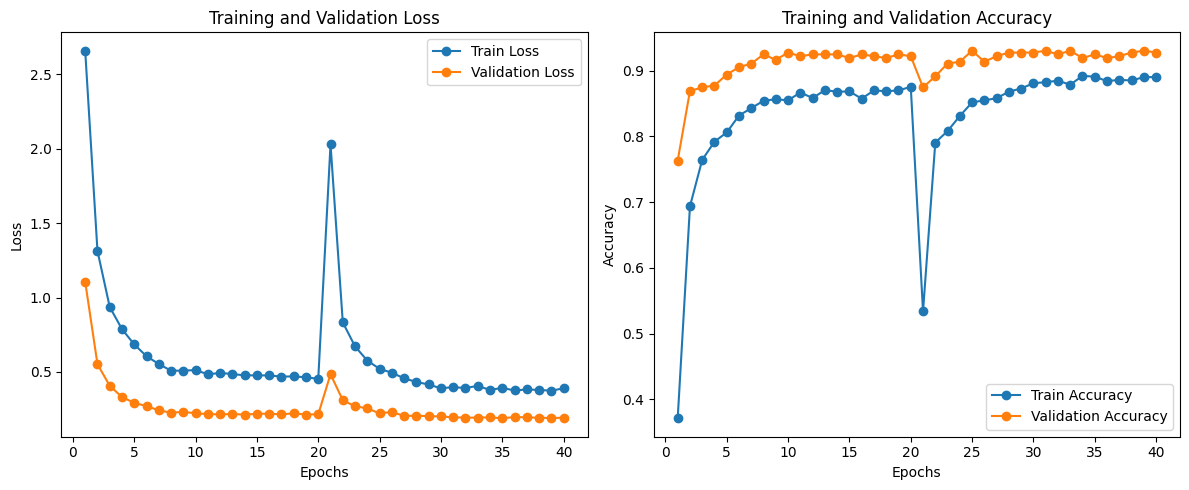

In [14]:
model = training_recognition_ai(model, train_dataset, val_dataset, save_dir)